In [164]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import tqdm
import math
import os
import xgboost
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

### Concept

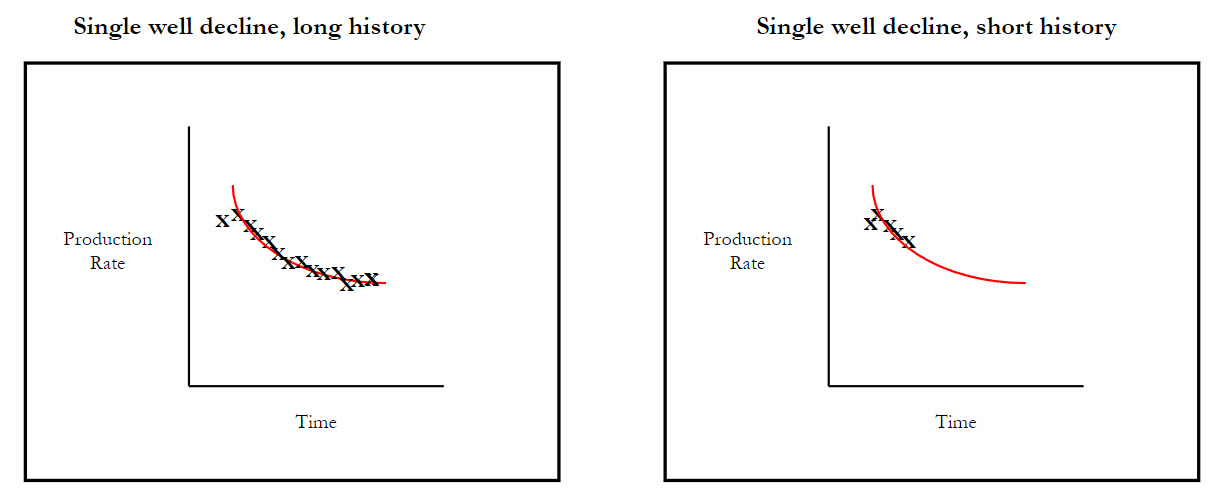

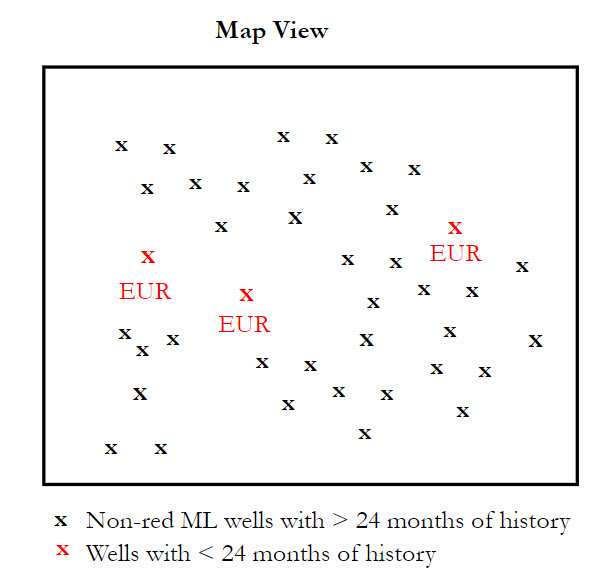

### Setup

In [165]:
'''
This code use wells with longer production history (>=25 months) as the input
And try to predict the wells with short history (<=24 months)
Featurs include the basic info of the well
Using XGBoost method
'''


n_fold = 5

featureName = [
    'IP180', 
    'Non.EDC_Qi',
    'Non.EDC_b',
    'Non.EDC_Di',    
    'Surface.Latitude', 
    'Surface.Longitude', 
    'Lateral.Length', 
    'Length_of_Outliers', 
    'Volatility', 
    'IP180perEUR',
    'TVD',
    'Jan_Year_Position'
]

cont_features = featureName.copy()

### Load Data

In [166]:
%cd "G:\My Drive\Veld_Code\EFG\v811"

G:\My Drive\Veld_Code\EFG\v811


In [167]:

# Input Data
check_df = pd.read_csv('Hist_Gas_w_ML_Merge.csv')

check_df['Volatility'] = check_df['X2016_Train_Volatility']
check_df = check_df[~check_df['Volatility'].isna()]

check_df.shape

(6110, 124)

### Split the data into training set and test set

In [168]:

# use longer history wells as the train data
dev_df = check_df[(check_df['Jan_Year_Position'] >= 25)  & 
                  (check_df['Jan_Year_Position'] <= 60)  &
                  (check_df['color_10'] == 3)]

# use short history wells as the test data
test_df  = check_df[(check_df['Jan_Year_Position'] <= 24) &
                    (check_df['Jan_Year_Position'] >= 7) 
                   ]


print("# of wells in training set: {} \n# of wells in test set: {}".format(len(dev_df), len(test_df)))

# of wells in training set: 1181 
# of wells in test set: 617


### Feature selection

In [169]:
dev_inputs = dev_df[featureName]
test_inputs  = test_df[featureName]

dev_inputs.loc[:, 'labels'] = np.asarray(dev_df['Calculated.30.yr.EUR'])
test_labels = test_df['Calculated.30.yr.EUR']

print(dev_df.shape)
print(test_df.shape)

(1181, 124)
(617, 124)


<AxesSubplot:>

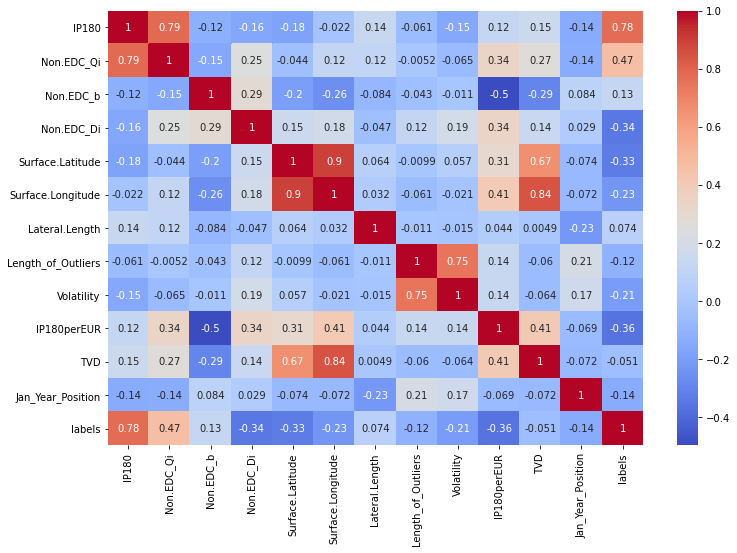

In [170]:
corr = dev_inputs.corr()
fig, ax = plt.subplots(figsize=(12,8)) 
sns.heatmap(corr, cmap="coolwarm", annot=True)

In [171]:
dev_inputs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1181 entries, 121 to 6049
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   IP180               1181 non-null   float64
 1   Non.EDC_Qi          1181 non-null   float64
 2   Non.EDC_b           1181 non-null   float64
 3   Non.EDC_Di          1181 non-null   float64
 4   Surface.Latitude    1181 non-null   float64
 5   Surface.Longitude   1181 non-null   float64
 6   Lateral.Length      1181 non-null   float64
 7   Length_of_Outliers  1181 non-null   int64  
 8   Volatility          1181 non-null   float64
 9   IP180perEUR         1181 non-null   float64
 10  TVD                 1181 non-null   float64
 11  Jan_Year_Position   1181 non-null   int64  
 12  labels              1181 non-null   float64
dtypes: float64(11), int64(2)
memory usage: 129.2 KB


In [172]:
test_inputs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 617 entries, 6 to 6108
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   IP180               617 non-null    float64
 1   Non.EDC_Qi          617 non-null    float64
 2   Non.EDC_b           617 non-null    float64
 3   Non.EDC_Di          617 non-null    float64
 4   Surface.Latitude    617 non-null    float64
 5   Surface.Longitude   617 non-null    float64
 6   Lateral.Length      617 non-null    float64
 7   Length_of_Outliers  617 non-null    int64  
 8   Volatility          617 non-null    float64
 9   IP180perEUR         617 non-null    float64
 10  TVD                 617 non-null    float64
 11  Jan_Year_Position   617 non-null    int64  
dtypes: float64(10), int64(2)
memory usage: 62.7 KB


In [174]:
dev_inputs.describe()

,IP180,Non.EDC_Qi,Non.EDC_b,Non.EDC_Di,Surface.Latitude,Surface.Longitude,Lateral.Length,Length_of_Outliers,Volatility,IP180perEUR,TVD,Jan_Year_Position,labels
count,1.181000e+03,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1181.000000,1.181000e+03
mean,4.158204e+05,4012.120539,0.950757,3.246447,28.411864,-98.999959,6023.896131,0.655377,0.060012,0.190589,9859.020745,44.200677,2.555095e+06
std,2.779187e+05,2561.748560,0.356128,2.746769,0.472373,0.963479,1287.644391,1.497664,0.079158,0.085755,2443.529997,10.010987,2.221059e+06
min,0.000000e+00,101.028266,0.600000,0.300000,27.665216,-100.176247,2276.000000,0.000000,0.003722,0.000000,4148.900000,25.000000,9.744033e+04
25%,2.389190e+05,2288.173703,0.600000,1.327295,28.138073,-99.738640,5214.000000,0.000000,0.017176,0.128924,8087.700000,36.000000,1.277209e+06
50%,3.670320e+05,3663.571297,0.854585,2.240109,28.284027,-99.505798,5789.312169,0.000000,0.029486,0.181072,9048.200000,45.000000,1.897704e+06
75%,5.230090e+05,5241.753040,1.196026,4.021396,28.659815,-98.087799,6739.342857,1.000000,0.061787,0.242100,12440.700000,53.000000,2.855998e+06
max,2.373687e+06,20229.487290,1.600000,10.000000,31.026678,-94.235481,12201.000000,19.000000,0.515914,0.621810,16200.400000,60.000000,1.899740e+07


In [175]:
test_inputs.describe()

,IP180,Non.EDC_Qi,Non.EDC_b,Non.EDC_Di,Surface.Latitude,Surface.Longitude,Lateral.Length,Length_of_Outliers,Volatility,IP180perEUR,TVD,Jan_Year_Position
count,6.170000e+02,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000
mean,6.010651e+05,5825.444406,0.912758,3.958373,28.422959,-99.008370,6630.985446,0.320908,0.037765,0.245371,9972.446191,17.113452
std,4.860553e+05,4172.382370,0.399833,3.309814,0.523394,1.012573,1492.089533,0.982361,0.090113,0.140589,2199.284823,5.228242
min,1.256000e+03,41.553329,0.300000,0.300000,27.669157,-100.065201,2444.000000,0.000000,0.000000,0.000421,3214.000000,7.000000
25%,2.702720e+05,2703.408041,0.600000,1.366746,28.076040,-99.765091,5616.000000,0.000000,0.000000,0.139744,8084.300000,13.000000
50%,4.344440e+05,4821.457928,0.728714,2.618722,28.285597,-99.530243,6425.044809,0.000000,0.012165,0.215552,9432.700000,18.000000
75%,7.771420e+05,8113.578258,1.210889,5.816137,28.765915,-97.989777,7326.000000,0.000000,0.026399,0.329922,12308.000000,22.000000
max,2.438884e+06,29486.118580,1.800000,10.000000,31.042372,-93.635666,13267.104570,10.000000,0.685462,0.815387,13792.000000,24.000000


### 5-Fold

In [177]:
cv=KFold(n_splits=5)
train_indices = []

train_df_folds, valid_df_folds, train_labels_folds, valid_labels_folds = [], [], [], []
for train_index, test_index in cv.split(dev_inputs[cont_features]):
    train_indices.append(train_index)
    train_df_folds.append(dev_inputs.iloc[train_index, :])
    valid_df_folds.append(dev_inputs.iloc[test_index, :])
    train_labels_folds.append(np.asarray(dev_inputs['labels'])[train_index])
    valid_labels_folds.append(np.asarray(dev_inputs['labels'])[test_index])

### XGBoost

In [178]:
xgb_model = xgboost.XGBRFRegressor(n_estimators=250, learning_rate=1.0, gamma=0,
                           colsample_bytree=0.1, max_depth=9)

parameters = {
    "n_estimators" : [i for i in range(50, 250, 10)],
    # "eta"    : [0.3, 0.6, 0.9], 
    "max_depth"        : [i for i in range(2,10,2)],
    #  "gamma"            : [ 0.0, 0.1],
    "subsample" : [0.6, 0.8, 1.0],
    "colsample_bytree" : [0.4],
    "reg_lambda" : [1e-3, 1e-1, 1, 5]
     }

grid = GridSearchCV(xgb_model,
                    parameters, n_jobs=-1,
                    scoring="neg_mean_absolute_error",
                    cv=cv, verbose=2)

grid.fit(dev_inputs[cont_features], dev_inputs['labels'])

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBRFRegressor(base_score=None, booster=None,
                                      colsample_bylevel=None,
                                      colsample_bytree=0.1, gamma=0,
                                      gpu_id=None, importance_type='gain',
                                      interaction_constraints=None,
                                      learning_rate=1.0, max_delta_step=None,
                                      max_depth=9, min_child_weight=None,
                                      missing=nan, monotone_constraints=None,
                                      n_es...
                                      random_state=None, reg_alpha=None,
                                      scale_pos_weight=None, tree_method=None,
                                      validate_parameters=None,
                                      verbosity=None),
             n_jobs=-1,
             para

In [179]:
## Fold 1
score_sort = pd.DataFrame(grid.cv_results_)
score_sort.sort_values(by='split0_test_score', axis=0, inplace=True, ascending=False)
sort_top = score_sort[param_list][:1]

xgboost1 = xgboost.XGBRFRegressor(n_estimators=int(sort_top['param_n_estimators']), 
                                 max_depth=int(sort_top['param_max_depth']), 
                                 subsample=float(sort_top['param_subsample']), 
                                 colsample_bytree=float(sort_top['param_colsample_bytree']), 
                                 reg_lambda=float(sort_top['param_reg_lambda']))
xgboost1.fit(train_df_folds[0][cont_features], train_labels_folds[0])
clf1_proba = xgboost1.predict(test_inputs[cont_features])
clf1_train = xgboost1.predict(train_df_folds[0][cont_features])
# print(sort_top)

## Fold 2
score_sort = pd.DataFrame(grid.cv_results_)
score_sort.sort_values(by='split1_test_score', axis=0, inplace=True, ascending=False)
sort_top = score_sort[param_list][:1]

xgboost2 = xgboost.XGBRFRegressor(n_estimators=int(sort_top['param_n_estimators']), 
                                 max_depth=int(sort_top['param_max_depth']), 
                                 subsample=float(sort_top['param_subsample']), 
                                 colsample_bytree=float(sort_top['param_colsample_bytree']), 
                                 reg_lambda=float(sort_top['param_reg_lambda']))
xgboost2.fit(train_df_folds[1][cont_features], train_labels_folds[1])
clf2_proba = xgboost2.predict(test_inputs[cont_features])
clf2_train = xgboost2.predict(train_df_folds[1][cont_features])

## Fold 3
score_sort = pd.DataFrame(grid.cv_results_)
score_sort.sort_values(by='split2_test_score', axis=0, inplace=True, ascending=False)
sort_top = score_sort[param_list][:1]

xgboost3 = xgboost.XGBRFRegressor(n_estimators=int(sort_top['param_n_estimators']), 
                                 max_depth=int(sort_top['param_max_depth']), 
                                 subsample=float(sort_top['param_subsample']), 
                                 colsample_bytree=float(sort_top['param_colsample_bytree']), 
                                 reg_lambda=float(sort_top['param_reg_lambda']))
xgboost3.fit(train_df_folds[2][cont_features], train_labels_folds[2])
clf3_proba = xgboost3.predict(test_inputs[cont_features])
clf3_train = xgboost3.predict(train_df_folds[2][cont_features])

## Fold 4
score_sort = pd.DataFrame(grid.cv_results_)
score_sort.sort_values(by='split3_test_score', axis=0, inplace=True, ascending=False)
sort_top = score_sort[param_list][:1]

xgboost4 = xgboost.XGBRFRegressor(n_estimators=int(sort_top['param_n_estimators']), 
                                 max_depth=int(sort_top['param_max_depth']), 
                                 subsample=float(sort_top['param_subsample']), 
                                 colsample_bytree=float(sort_top['param_colsample_bytree']), 
                                 reg_lambda=float(sort_top['param_reg_lambda']))
xgboost4.fit(train_df_folds[3][cont_features], train_labels_folds[3])
clf4_proba = xgboost4.predict(test_inputs[cont_features])
clf4_train = xgboost4.predict(train_df_folds[3][cont_features])


## Fold 5
score_sort = pd.DataFrame(grid.cv_results_)
score_sort.sort_values(by='split4_test_score', axis=0, inplace=True, ascending=False)
sort_top = score_sort[param_list][:1]

xgboost5 = xgboost.XGBRFRegressor(n_estimators=int(sort_top['param_n_estimators']), 
                                 max_depth=int(sort_top['param_max_depth']), 
                                 subsample=float(sort_top['param_subsample']), 
                                 colsample_bytree=float(sort_top['param_colsample_bytree']), 
                                 reg_lambda=float(sort_top['param_reg_lambda']))
xgboost5.fit(train_df_folds[4][cont_features], train_labels_folds[4])
clf5_proba = xgboost5.predict(test_inputs[cont_features])
clf5_train = xgboost5.predict(train_df_folds[4][cont_features])




avg_proba = np.sum([clf1_proba, clf2_proba, clf3_proba, clf4_proba, clf5_proba], axis=0 ) / 5


In [180]:
print("fold 1 r2",r2_score(test_labels, clf1_proba))
print("fold 2 r2",r2_score(test_labels, clf2_proba))
print("fold 3 r2",r2_score(test_labels, clf3_proba))
print("fold 4 r2",r2_score(test_labels, clf4_proba))
print("fold 5 r2",r2_score(test_labels, clf5_proba))
print("average r2",r2_score(test_labels, avg_proba))

fold 1 r2 0.7518887796503703
fold 2 r2 0.776924637711306
fold 3 r2 0.777561312505308
fold 4 r2 0.7825357517361654
fold 5 r2 0.7082579649443994
average r2 0.7727434172383267


In [181]:
print("fold 1 rmse", mean_squared_error(test_labels, clf1_proba, squared=False))
print("fold 2 rmse",mean_squared_error(test_labels, clf2_proba, squared=False))
print("fold 3 rmse",mean_squared_error(test_labels, clf3_proba, squared=False))
print("fold 4 rmse",mean_squared_error(test_labels, clf4_proba, squared=False))
print("fold 5 rmse",mean_squared_error(test_labels, clf5_proba, squared=False))
print("average rmse", mean_squared_error(test_labels, avg_proba,  squared=False))

fold 1 rmse 1423292.405927854
fold 2 rmse 1349574.0944411778
fold 3 rmse 1347646.82250746
fold 4 rmse 1332492.777471174
fold 5 rmse 1543371.3489196205
average rmse 1362163.2703622929


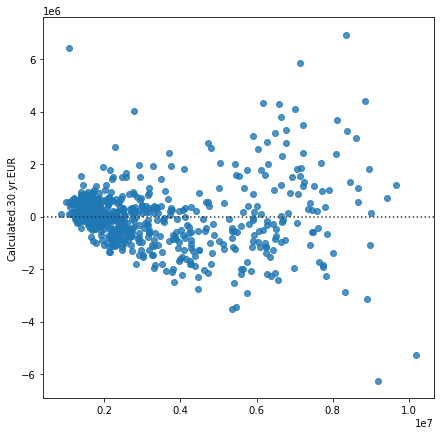

In [182]:
sns.residplot(avg_proba, test_labels)

plt.show()

### Evaluation
**Stats of ML**

In [197]:
predictions = np.asarray(avg_proba)
test_labels = np.asarray(test_labels)

print('MEAN y_hat is {}'.format(np.mean(np.abs(predictions))))
print('MEAN ground truth is {}'.format(np.mean(np.abs(test_labels))))
print('MAE is {}'.format(np.mean(np.abs((test_labels - predictions)))))
print('Std of MAE is {}'.format(np.std(np.abs((test_labels - predictions)))))
print("RMSE score: {}".format(mean_squared_error(test_labels, predictions, squared=False)))
print("R2 score: {}".format(r2_score(test_labels, predictions)))

MEAN y_hat is 3343677.5
MEAN ground truth is 3137762.675733728
MAE is 959485.5935928524
Std of MAE is 966889.9476216871
RMSE score: 1362163.2703622929
R2 score: 0.7727434172383267


In [198]:
test_df

,API_10,API.Number,Months.Prior,Primary.Formation,Lateral.Length,Surface.Latitude,Surface.Longitude,Volatility,X2019Qi,X2019Di,...,acc_25.1,color_25_Run2,API,truth_10_y,preds_10_y,acc_10_y,color_10_Run2,labels,predictions,Percentage_Error
6,4225534866,42255348660000,58,EAGLE FORD,4907.000000,28.867037,-97.741417,0.377334,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.351040e+05,1.411262e+06,0.689924
15,4231136560,42311365600000,58,EAGLE FORD,7217.000000,28.370302,-98.468697,0.274793,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.636331e+06,2.923518e+06,0.786630
18,4212737140,42127371400000,56,EAGLE FORD,6344.729475,28.347580,-99.782410,0.023514,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.341760e+05,1.996579e+06,1.137263
23,4247942928,42479429280000,57,EAGLE FORD,7910.206897,28.059032,-99.765137,0.095254,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.381107e+06,5.465004e+06,1.295153
27,4212737320,42127373200000,51,EAGLE FORD,6161.000000,28.250574,-99.557587,0.008344,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.158529e+06,2.925081e+06,1.524823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6063,4228334308,42283343080000,56,EAGLE FORD,9549.159126,28.412683,-99.355507,0.000000,0,0,...,0.241301,1.0,4.228330e+13,0.241301,0.432593,0.241301,1.0,1.592118e+06,1.533537e+06,0.036795
6064,4212736585,42127365850000,60,EAGLE FORD,7081.826884,28.264332,-100.029526,0.000000,0,0,...,0.232780,1.0,4.212740e+13,0.232780,0.489088,0.232780,1.0,1.903129e+06,1.665868e+06,0.124669
6092,4201335175,42013351750000,73,EAGLE FORD,5509.274725,28.724562,-98.675650,0.459774,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.142169e+04,8.561313e+05,8.364641
6094,4212736708,42127367080000,53,EAGLE FORD,6882.688474,28.392443,-99.444504,0.000000,0,0,...,0.118194,1.0,4.212740e+13,0.118194,0.287051,0.118194,1.0,1.529174e+06,1.447816e+06,0.053204


In [192]:
test_df['labels'] = test_labels.tolist()
test_df['predictions'] = predictions
a =  np.abs( (test_labels - predictions) / test_labels )
test_df['Percentage_Error'] = a.tolist()
test_df.to_csv('test_df_2018_New.csv',index=False)

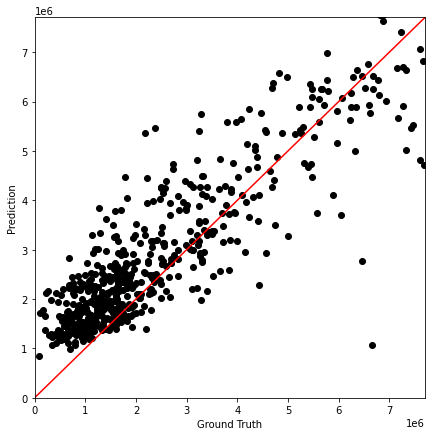

In [193]:
GT = test_labels
PREDS = predictions


fig, ax = plt.subplots()
ax.scatter(GT, PREDS, c='black')
line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
plt.xlim([0, 4*np.median(GT)])
plt.ylim([0, 4*np.median(GT)])
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.rcParams["figure.figsize"] = (7, 7)
plt.show()


In [194]:
print( len(GT) )
print( len(PREDS) )
print( 100 * (np.sum(PREDS > GT)) / len(GT))
print( 100 * (np.sum(PREDS < GT)) / len(GT))
print( r2_score(GT, PREDS) )

617
617
70.82658022690437
29.173419773095624
0.7727434172383267


**Stats of baseline**

In [199]:
baselines = np.asarray(hist_df[hist_df['API.Number'].isin(test_df['API.Number'])]['EUR_30yrs_Non_EDC'])


print('MEAN y_hat is {}'.format(np.mean(np.abs(baselines))))
print('MEAN ground truth is {}'.format(np.mean(np.abs(test_labels))))
print('MAE is {}'.format(np.mean(np.abs((test_labels - baselines)))))
print('Std of MAE is {}'.format(np.std(np.abs((test_labels - baselines)))))
print("RMSE score: {}".format(mean_squared_error(test_labels, baselines, squared=False)))
print("R2 score: {}".format(r2_score(test_labels, baselines)))



MEAN y_hat is 3055028.4595788247
MEAN ground truth is 3137762.675733728
MAE is 1040491.3536061182
Std of MAE is 1493002.239515363
RMSE score: 1819801.6221904468
R2 score: 0.5943922577816907


### Feature Importance

<BarContainer object of 10 artists>

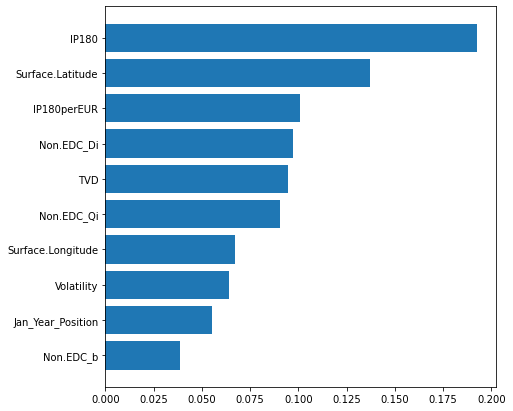

In [196]:
plt.rcParams["figure.figsize"] = (7, 7)
# xgboost.plot_importance(xgboost1)
# plt.show()
ensemble_importance = (xgboost1.feature_importances_ + xgboost2.feature_importances_ + xgboost3.feature_importances_ + xgboost4.feature_importances_ + xgboost5.feature_importances_) / 5

sorted_idx = ensemble_importance.argsort()[::-1]
# print(evenness_features)
# print(np.asarray(evenness_features)[sorted_idx])
plt.barh(np.asarray(cont_features)[sorted_idx][:10][::-1], ensemble_importance[sorted_idx][:10][::-1])